<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template and tests for an LSTM Auto-Encoder


In [1]:
import numpy as np
import scipy
from scipy.stats import special_ortho_group
import matplotlib.pyplot as plt

import scipy

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Layer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed, Input, Lambda, Masking
import tensorflow.keras.backend as K

#### create some fake data



In [2]:
dim = 30
Nsamples = 50000
eig = np.logspace(-3,3,dim)
R   = scipy.stats.special_ortho_group.rvs(dim)
cov = np.dot(R,np.dot(np.diag(eig), R.T))
L   = np.linalg.cholesky(cov)

In [3]:
data  = np.expand_dims(np.einsum('jk,ik->ij',L,np.random.randn(Nsamples,dim),optimize=True),-1)
masks = np.random.random(data.shape)<0.75

In [4]:
m_data = data*masks

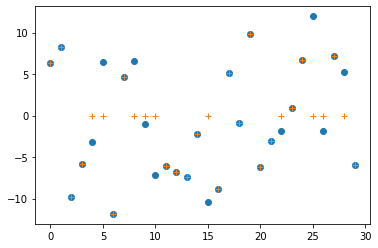

In [5]:
plt.plot(data[0], ls='', marker='o')
plt.plot(m_data[0], ls='', marker='+')

In [6]:
data_train = data[0:30000]
data_val   = data[30000:40000]
data_test  = data[40000:50000]

### write a simple LSTM model

In [7]:
latent_dim = 10

class bottleneck(Layer):
    def __init__(self, units, dim, **kwargs):
        self.units  = units
        self.dim    = dim
        self.LSTM   = LSTM(units, return_sequences=False)
        self.Repeat = RepeatVector(dim)
        super(bottleneck, self).__init__(**kwargs)

    def call(self, inputs):
        return self.Repeat(self.LSTM(inputs))

    def compute_mask(self, inputs, mask=None):
        return mask


input = Input(shape=(dim, 1))
x     = Masking(mask_value=0)(input)
x     = bottleneck(units=latent_dim, dim=dim)(x)
x     = LSTM(latent_dim, return_sequences=True)(x)
x     = Dense(1)(x)
lstm_ae = Model(inputs=input, outputs=x)
lstm_ae.compile(optimizer='adam', loss='mse')
print(lstm_ae.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 1)]           0         
_________________________________________________________________
masking (Masking)            (None, 30, 1)             0         
_________________________________________________________________
bottleneck (bottleneck)      (None, 30, 10)            480       
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 10)            840       
_________________________________________________________________
dense (Dense)                (None, 30, 1)             11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
for i, l in enumerate(lstm_ae.layers):
    print(f'layer {i}: {l}')
    print(f'has input mask: {l.input_mask}')
    print(f'has output mask: {l.output_mask}')

layer 0: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x2aab3c847340>
has input mask: None
has output mask: None
layer 1: <tensorflow.python.keras.layers.core.Masking object at 0x2aab3c847a60>
has input mask: None
has output mask: Tensor("masking/Identity_1:0", shape=(None, 30), dtype=bool)
layer 2: <__main__.bottleneck object at 0x2aab3c8809a0>
has input mask: Tensor("masking/Identity_1:0", shape=(None, 30), dtype=bool)
has output mask: Tensor("masking/Identity_1:0", shape=(None, 30), dtype=bool)
layer 3: <tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x2aab3c8808b0>
has input mask: Tensor("masking/Identity_1:0", shape=(None, 30), dtype=bool)
has output mask: Tensor("masking/Identity_1:0", shape=(None, 30), dtype=bool)
layer 4: <tensorflow.python.keras.layers.core.Dense object at 0x2aab4fe84850>
has input mask: Tensor("masking/Identity_1:0", shape=(None, 30), dtype=bool)
has output mask: Tensor("masking/Identity_1:0", shape=(None, 30), dtype=bool)


In [9]:
history = lstm_ae.fit(data_train, data_train, validation_data=(data_val, data_val), batch_size=16, epochs=20, verbose=2)

Epoch 1/20
1875/1875 - 11s - loss: 82.3586 - val_loss: 77.8874
Epoch 2/20
1875/1875 - 10s - loss: 74.9177 - val_loss: 73.4567
Epoch 3/20
1875/1875 - 10s - loss: 71.3444 - val_loss: 70.0097
Epoch 4/20
1875/1875 - 10s - loss: 68.3172 - val_loss: 67.7226
Epoch 5/20
1875/1875 - 10s - loss: 64.8715 - val_loss: 63.0571
Epoch 6/20
1875/1875 - 10s - loss: 61.8221 - val_loss: 59.3524
Epoch 7/20
1875/1875 - 10s - loss: 58.4117 - val_loss: 57.1503
Epoch 8/20
1875/1875 - 10s - loss: 57.2887 - val_loss: 55.4478
Epoch 9/20
1875/1875 - 10s - loss: 57.5177 - val_loss: 55.5011
Epoch 10/20
1875/1875 - 10s - loss: 55.7155 - val_loss: 53.2244
Epoch 11/20
1875/1875 - 10s - loss: 56.2373 - val_loss: 53.4755
Epoch 12/20
1875/1875 - 10s - loss: 53.5568 - val_loss: 51.5432
Epoch 13/20
1875/1875 - 10s - loss: 52.3429 - val_loss: 53.9487
Epoch 14/20
1875/1875 - 10s - loss: 51.3543 - val_loss: 50.8125
Epoch 15/20
1875/1875 - 10s - loss: 52.7888 - val_loss: 49.0441
Epoch 16/20
1875/1875 - 10s - loss: 48.0850 - val

In [10]:
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
  # create an empty model
  new_model = Sequential()
  for ix in range(starting_layer_ix, ending_layer_ix + 1):
    curr_layer = main_model.get_layer(index=ix)
    # copy this layer over to the new model
    new_model.add(curr_layer)
  return new_model

In [11]:
encoder = Model(inputs=lstm_ae.inputs, outputs=lstm_ae.layers[2].output)
encoded = encoder.predict(data_val)
# decoder = extract_layers(model, 1, -1)
recon   = lstm_ae.predict(data_test)

In [12]:
encoded.shape

(10000, 30, 10)

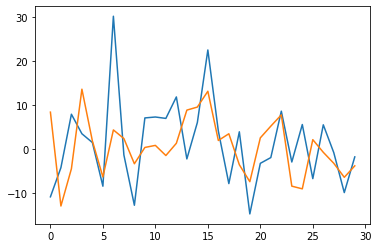

In [13]:
plt.plot(data_test[0])
plt.plot(recon[0])